# Welcome to Group O's Project for COMP3314 Machine Learning!

By the end of this notebook, you will be able to use, train and analyze your very own object detection model.

This is an overview of the notebook:
1. Demo of a pre-trained model
2. How to train the model on your own dataset
3. The different pre-processing steps involved to prepare the training data
4. An in-depth look into the steps performed to detect and segment objects. It provides visualizations of every step of the pipeline.

Let's start with the demo.

## 1. Demo of a pre-trained model
Let's start off with importing the required libraries, setting directory constants and creating a config.

In [1]:
import os
import random
import skimage.io
import colorsys
import mrcnn.utils as utils

ROOT_DIR = os.getcwd()
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrained_model.h5")
# Download COCO trained weights from https://github.com/matterport/Mask_RCNN/releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

import coco
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

... done downloading pretrained model!


Using TensorFlow backend.


In [2]:
import mrcnn.model as modellib

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

Processing 1 images
image                    shape: (476, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  119.30000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


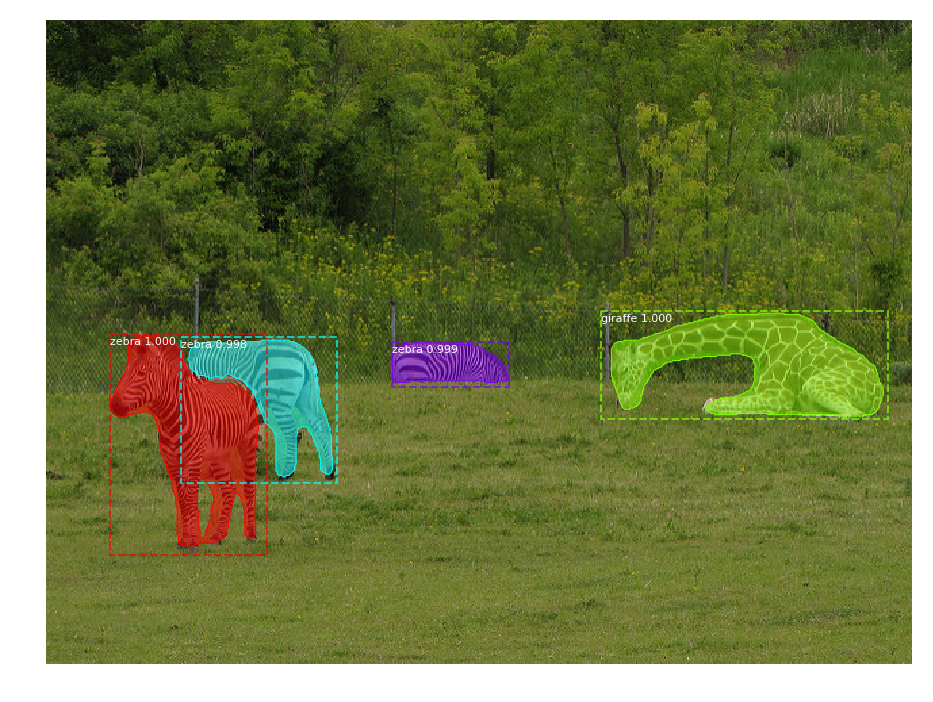

In [4]:
from mrcnn import visualize

# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# 2. Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. Plus, you won't have to wait hours to download the huge [COCO dataset](http://cocodataset.org/#home).

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [12]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

## Configurations

Before overriding the Config class, let's look at it first:

In [6]:
??Config

In [13]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

Let's look at the Dataset class first:

In [9]:
??utils.Dataset

In [14]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        # One image could have multiple shapes.
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes
    
    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)
    
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)
    
    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

In [15]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

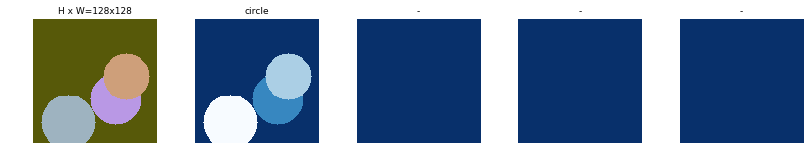

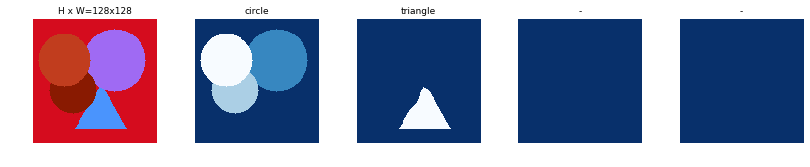

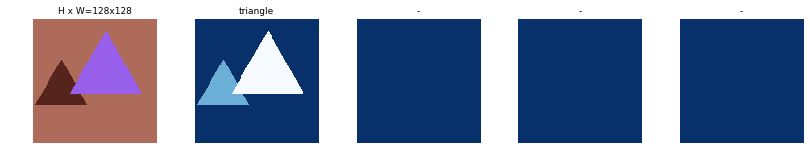

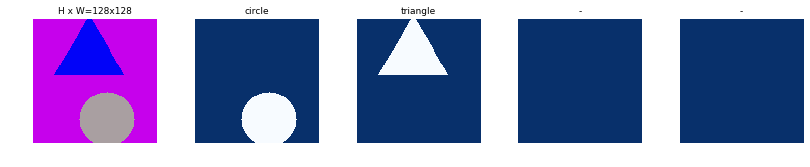

In [16]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

## Training

In [18]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /userhome/comp3314/c3314g15/MaskRCNN-Extension/Final (Single Notebook)/logs/shapes20190422T0749/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mr

/userhome/comp3314/c3314g15/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/userhome/comp3314/c3314g15/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 106s 1s/step - loss: 8.3401 - rpn_class_loss: 0.3422 - rpn_bbox_loss: 3.2671 - mrcnn_class_loss: 0.9072 - mrcnn_bbox_loss: 2.9904 - mrcnn_mask_loss: 0.8331 - val_loss: 5.9166 - val_rpn_class_loss: 0.0777 - val_rpn_bbox_loss: 3.0214 - val_mrcnn_class_loss: 0.3579 - val_mrcnn_bbox_loss: 1.8188 - val_mrcnn_mask_loss: 0.6409


## Detection

As we did in the demo, we need to create an inference configuration and load the model in inference mode.

In [19]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /userhome/comp3314/c3314g15/MaskRCNN-Extension/Final (Single Notebook)/logs/shapes20190422T0749/mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:   34.00000  max:  251.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:   40.00000  max:   92.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool


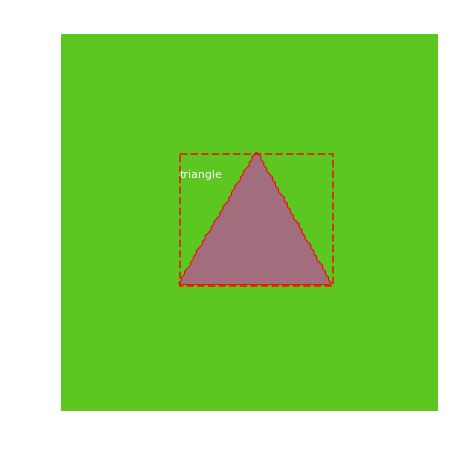

In [20]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   34.00000  max:  251.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -69.90000  max:  147.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


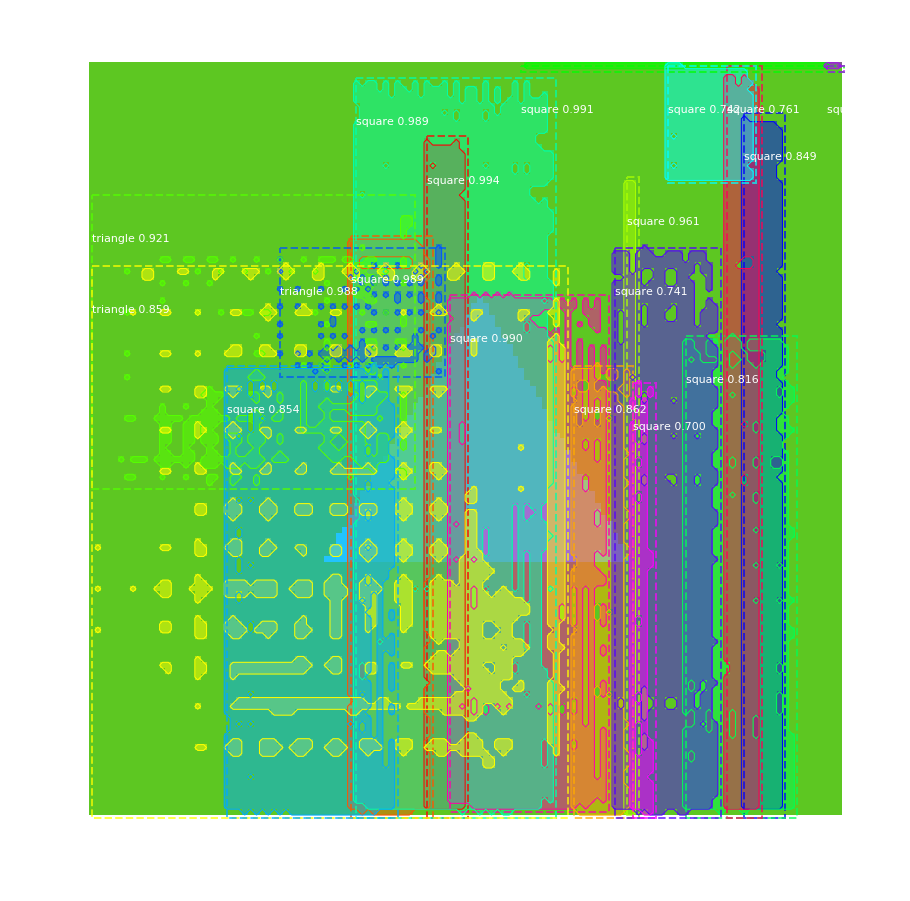

In [21]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

## Evaluation

Read [this](http://cocodataset.org/#detection-eval) to understand the evaluation metrics.

In [21]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.005085784372161417


# 3. Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

## Dataset

In [22]:
# Load dataset
dataset = ShapesDataset()
dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 500
Class Count: 4
  0. BG                                                
  1. square                                            
  2. circle                                            
  3. triangle                                          


## Display Samples

Load and display images and masks.

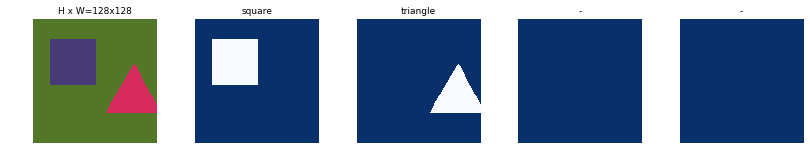

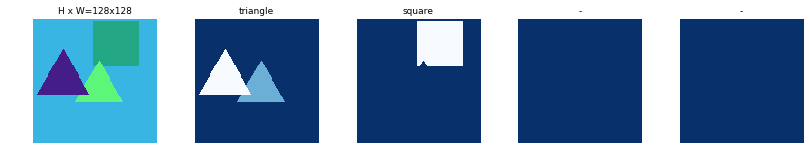

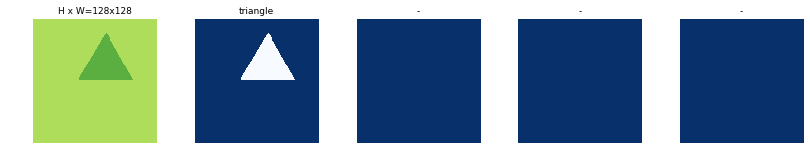

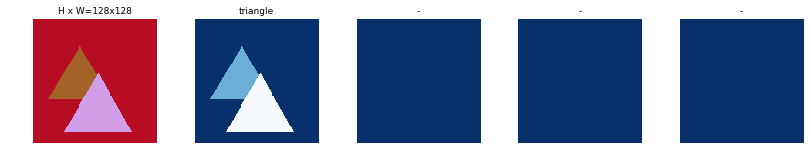

In [23]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Bounding boxes are boxes to describe the target location.

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  342 [('triangle', (211, 160, 47), (91, 20, 20)), ('square', (175, 146, 127), (36, 71, 24)), ('circle', (151, 111, 69), (81, 68, 23))]
image                    shape: (128, 128, 3)         min:   47.00000  max:  232.00000  uint8
mask                     shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    3.00000  int32
bbox                     shape: (3, 4)                min:    0.00000  max:  115.00000  int32


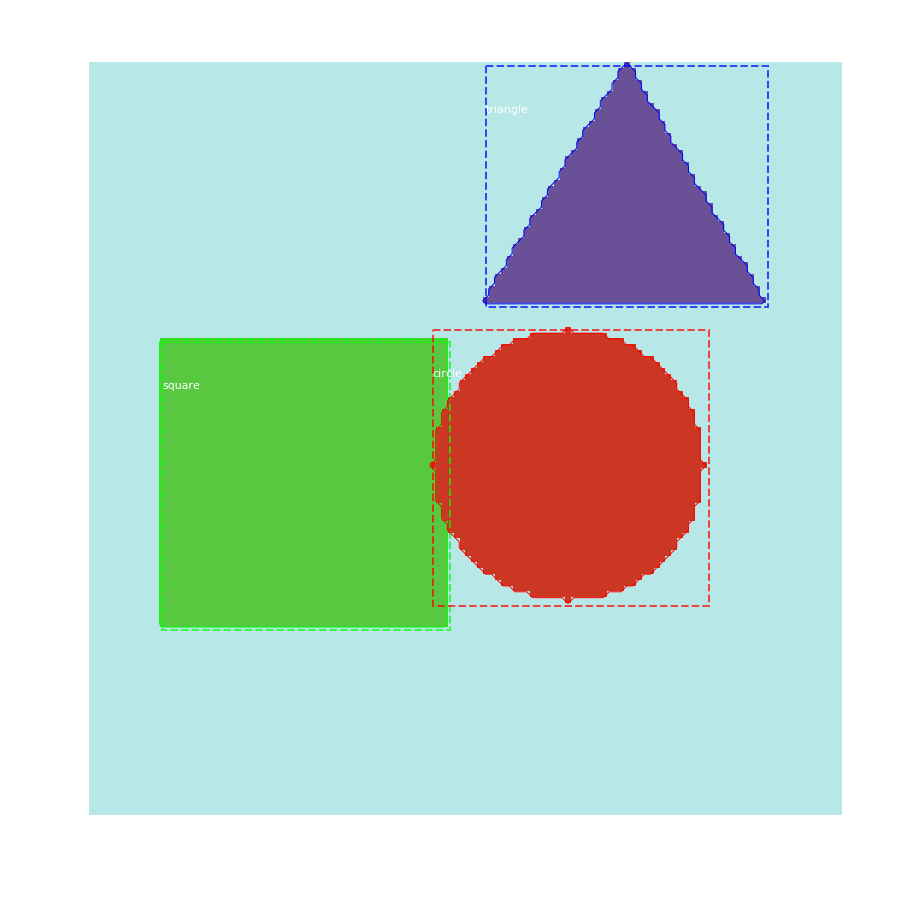

In [24]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  1 [('circle', (189, 231, 79), (95, 40, 30)), ('triangle', (172, 7, 196), (69, 107, 30)), ('circle', (194, 141, 2), (24, 54, 20))]
Original shape:  (128, 128, 3)
image                    shape: (128, 128, 3)         min:    2.00000  max:  233.00000  uint8
mask                     shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    2.00000  max:    3.00000  int32
bbox                     shape: (3, 4)                min:    4.00000  max:  128.00000  int32


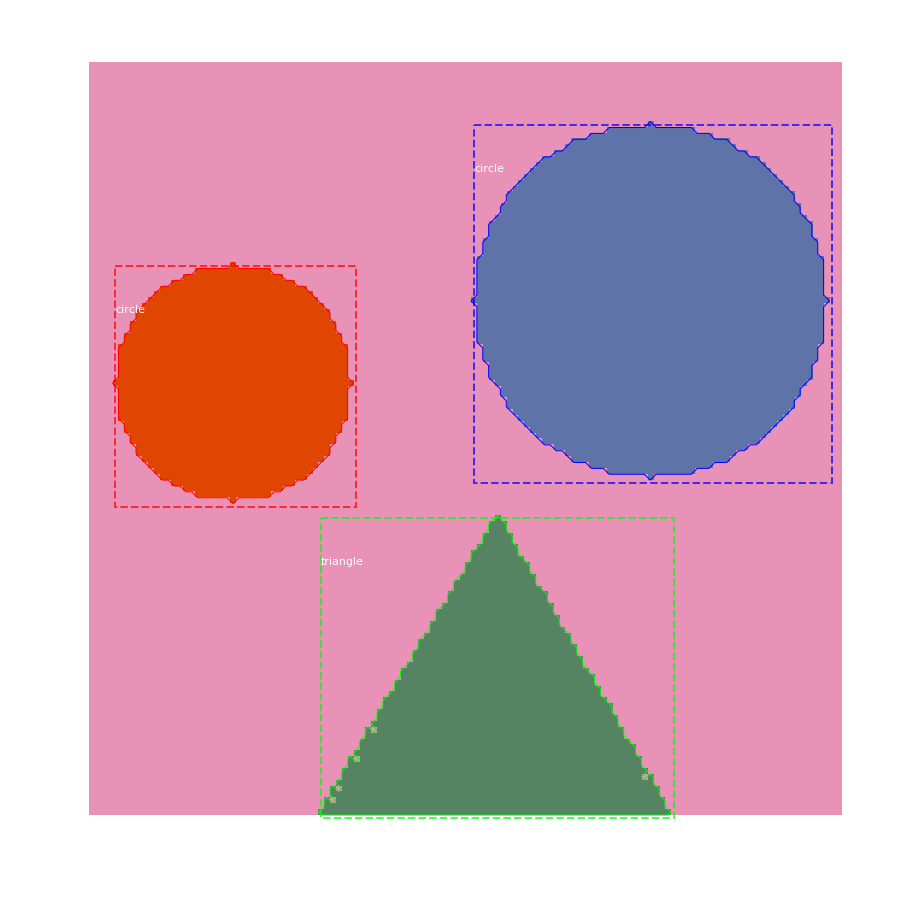

In [25]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (128, 128, 3)         min:   38.00000  max:  246.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  233.00000  int64
class_ids                shape: (2,)                  min:    1.00000  max:    3.00000  int32
bbox                     shape: (2, 4)                min:   22.00000  max:  122.00000  int32
mask                     shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


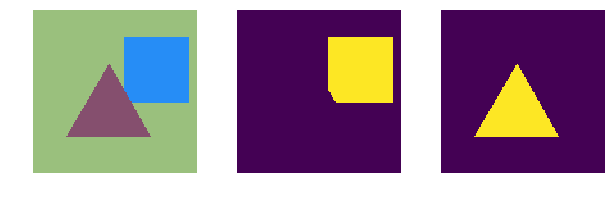

In [26]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

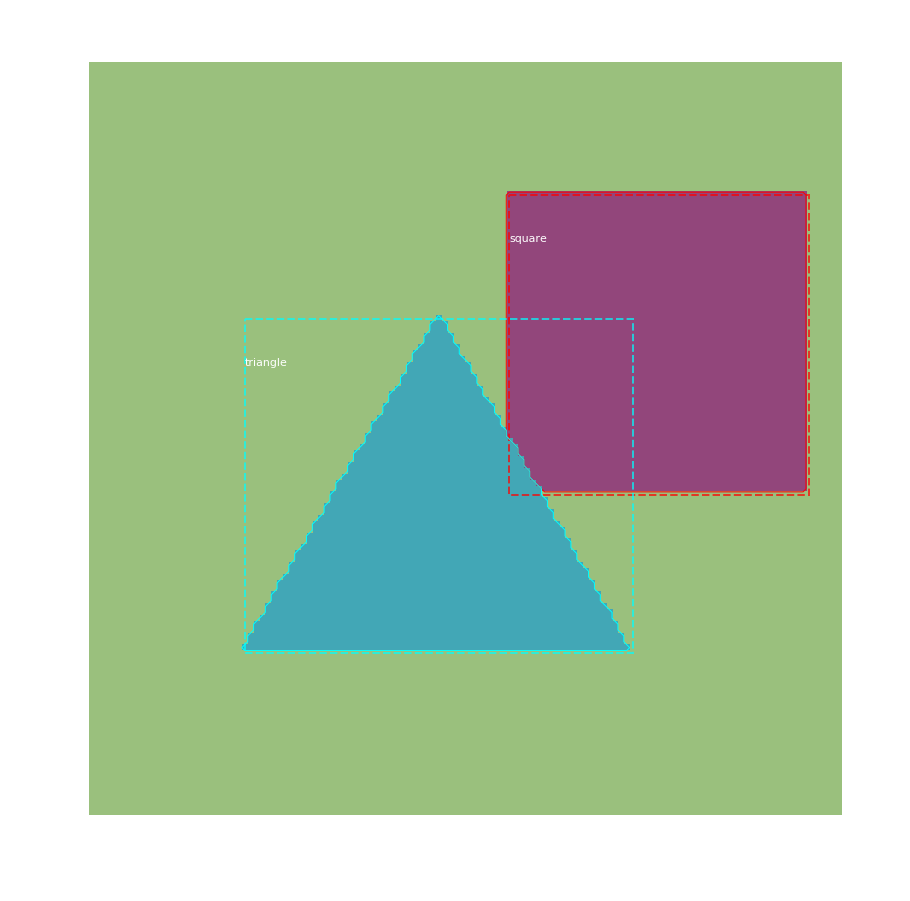

In [27]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 2)           min:    0.00000  max:    1.00000  bool


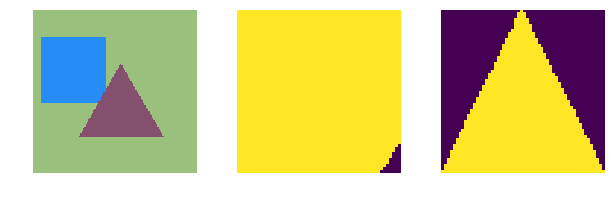

In [28]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

Read about augmentation and masks [here](https://mxnet.incubator.apache.org/versions/master/tutorials/python/data_augmentation_with_masks.html).

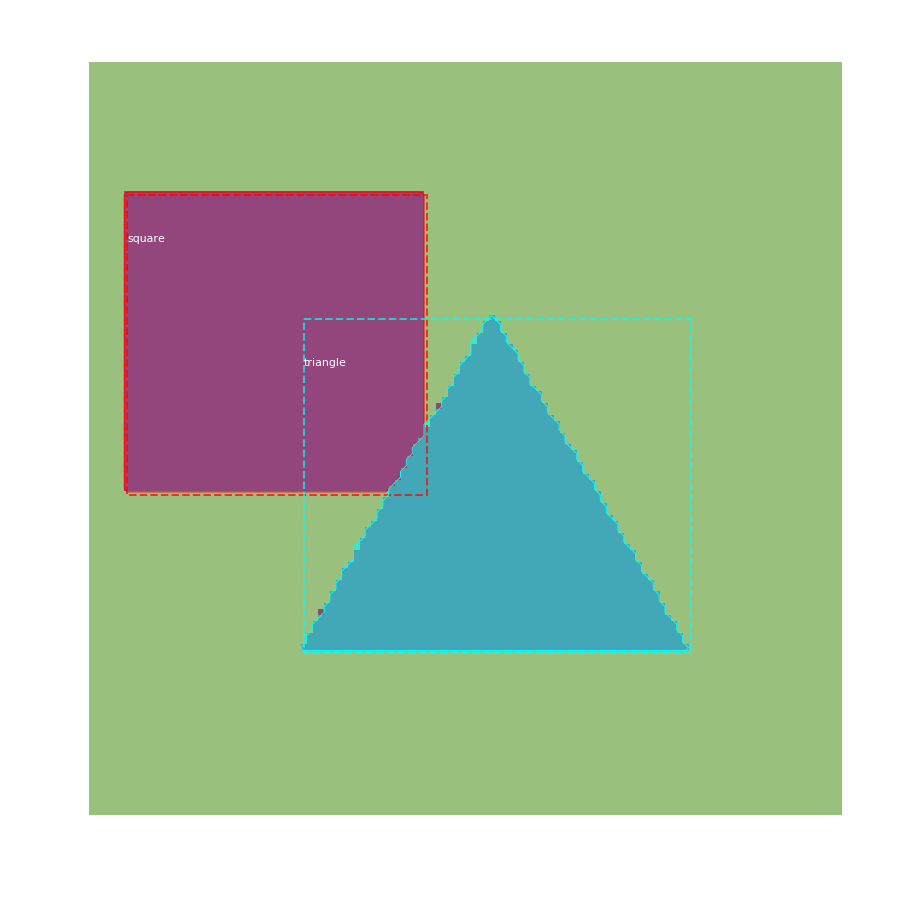

In [29]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

Read about anchors [here](https://medium.com/@andersasac/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9).

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an [Feature Pyramid Network](https://medium.com/@jonathan_hui/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c), the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256x256x3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [30]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  4092
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 3072
Anchors in Level 1: 768
Anchors in Level 2: 192
Anchors in Level 3: 48
Anchors in Level 4: 12


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors:   3072  Feature map Shape: [32 32]
Level 1. Anchors:    768  Feature map Shape: [16 16]
Level 2. Anchors:    192  Feature map Shape: [8 8]
Level 3. Anchors:     48  Feature map Shape: [4 4]
Level 4. Anchors:     12  Feature map Shape: [2 2]


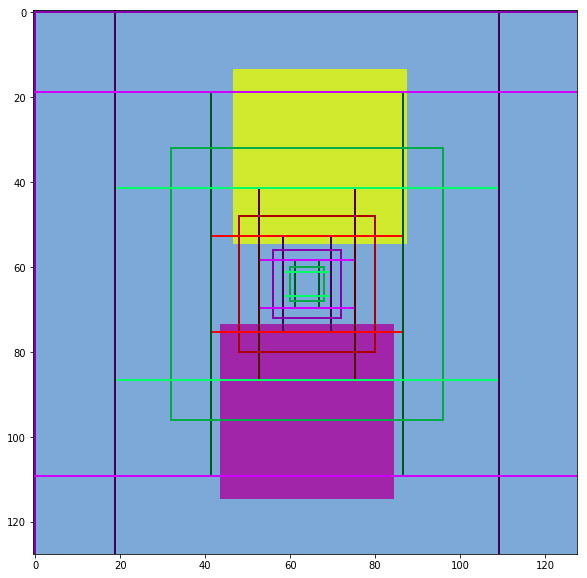

In [31]:
import matplotlib.patches as patches

## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [32]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [33]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 32, 4)            min:    0.00000  max:  127.00000  int32
mrcnn_class_ids          shape: (4, 32, 1)            min:    0.00000  max:    3.00000  int32
mrcnn_bbox               shape: (4, 32, 4, 4)         min:   -2.72727  max:    3.02326  float32
mrcnn_mask               shape: (4, 32, 28, 28, 4)    min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    3.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  128.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 4092, 1)          min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -2.86816  max:    2.43068  float64
image_id:  233 [('square', (38, 141, 246), (96, 47, 25)), ('triangle', (133, 79, 110), (59, 71, 28))]


anchors                  shape: (4092, 4)             min:  -90.50967  max:  154.50967  float64
refined_anchors          shape: (3, 4)                min:   22.00000  max:  122.00000  float32
Positive anchors: 3
Negative anchors: 253
Neutral anchors: 3836
BG                     : 22
square                 : 3
triangle               : 7


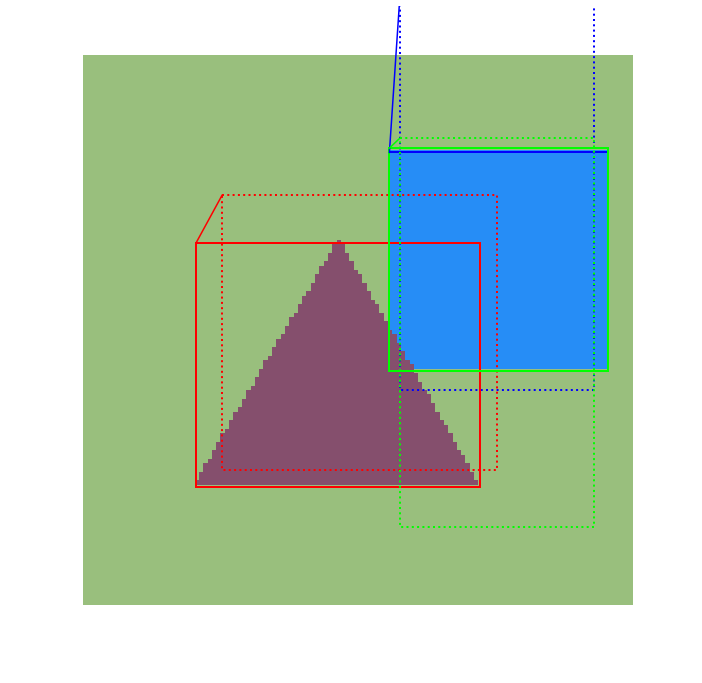

In [34]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

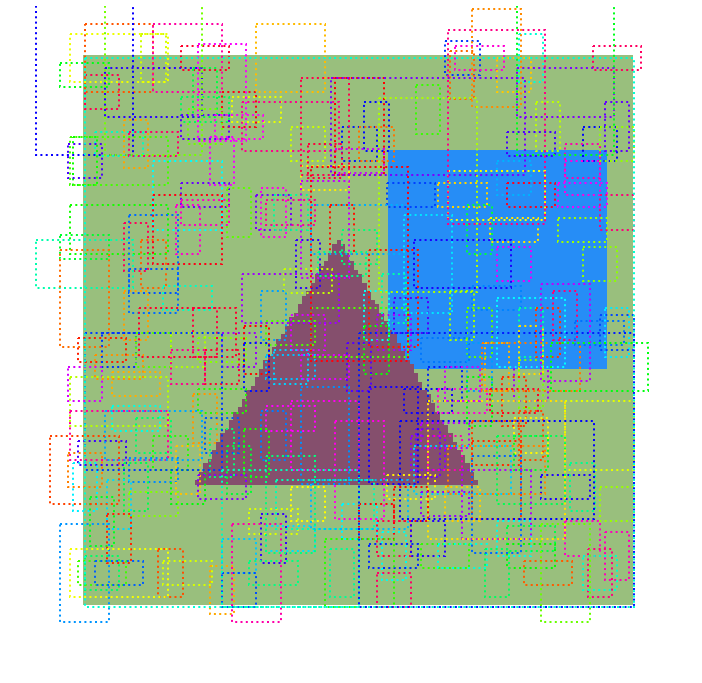

In [35]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

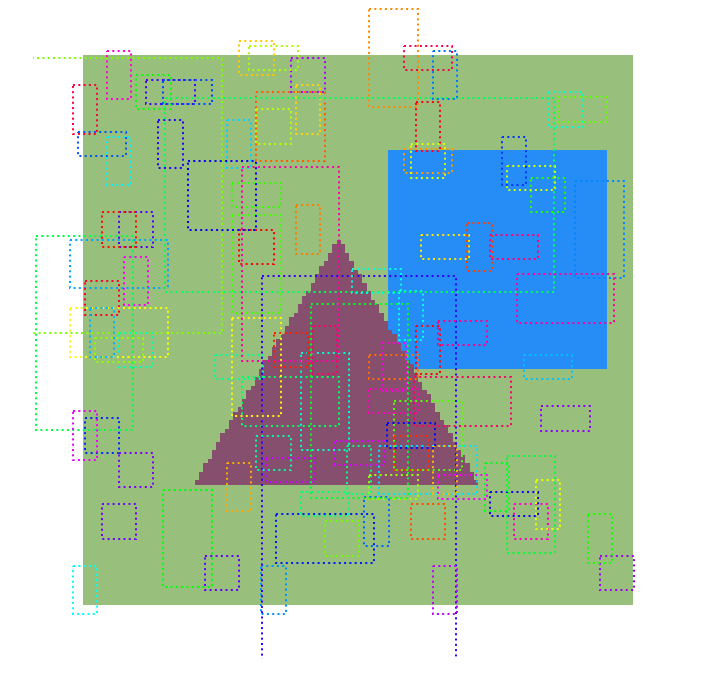

In [36]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  10
Negative ROIs:  22
Positive Ratio: 0.31
Unique ROIs: 32 out of 32


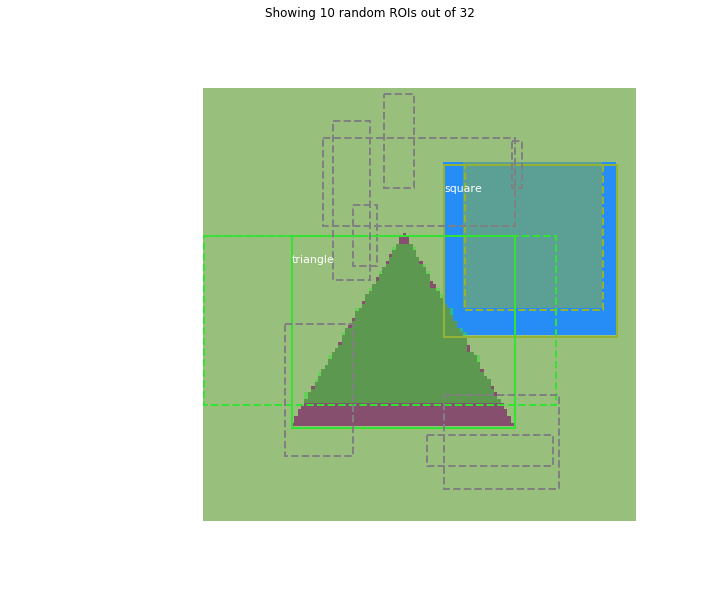

In [37]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

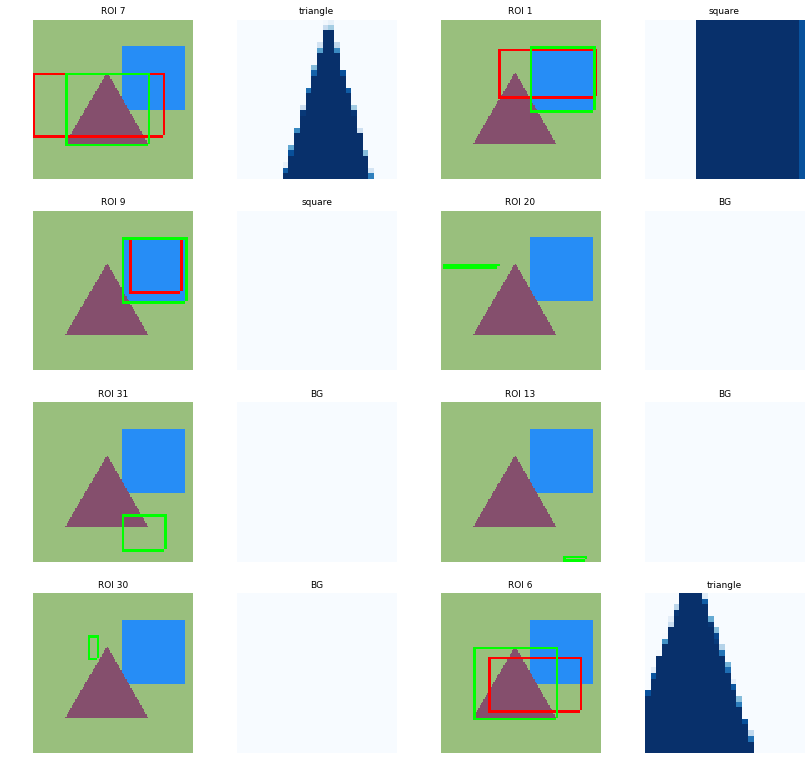

In [38]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    visualize.display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [39]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
Average percent: 0.31


## 4. Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

## Run Detection

image ID: shapes.484 (484) [('square', (85, 155, 192), (104, 21, 32))]
Processing 1 images
image                    shape: (128, 128, 3)         min:   25.00000  max:  192.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -91.80000  max:   88.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


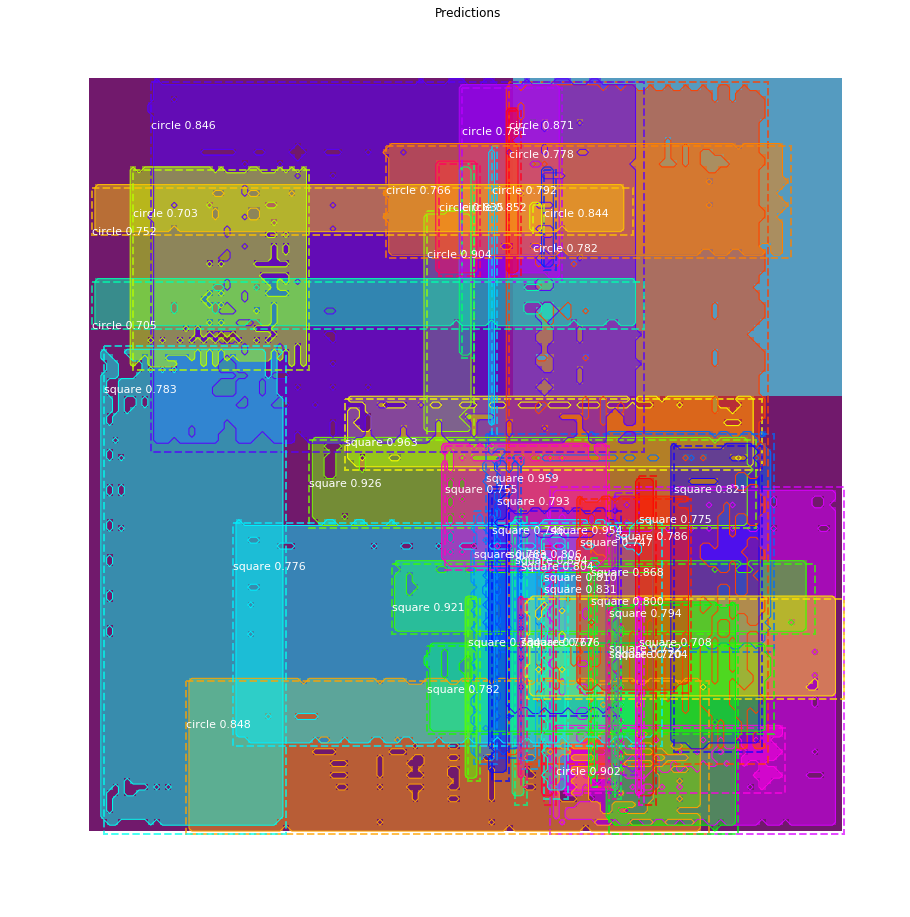

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool


In [40]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'],
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall

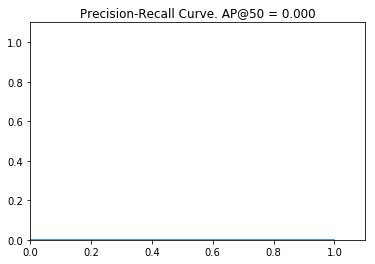

In [41]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

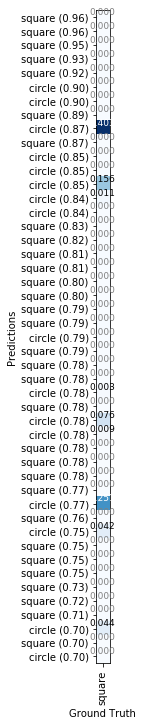

In [42]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [43]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.004761904903820583


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [44]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (4092,)               min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -0.84950  max:    0.62500  float64
positive_anchors         shape: (1, 4)                min:    0.00000  max:  128.00000  float64
negative_anchors         shape: (255, 4)              min:  -90.50967  max:  154.50967  float64
neutral anchors          shape: (3836, 4)             min:  -90.50967  max:  154.50967  float64
refined_anchors          shape: (1, 4)                min:    0.00000  max:  128.00000  float32


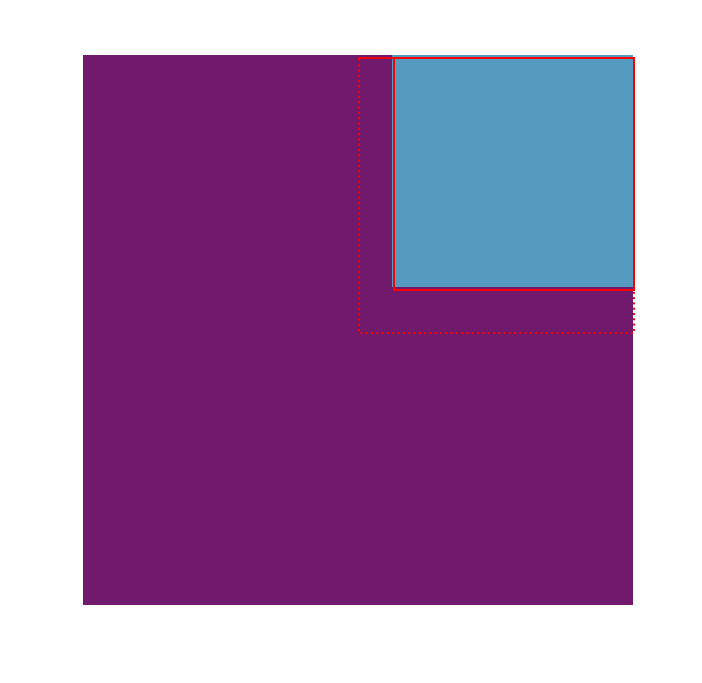

In [45]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [46]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 4092, 2)          min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
refined_anchors          shape: (1, 4092, 4)          min:  -87.41912  max:   88.23244  float32
refined_anchors_clipped  shape: (1, 4092, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1615.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


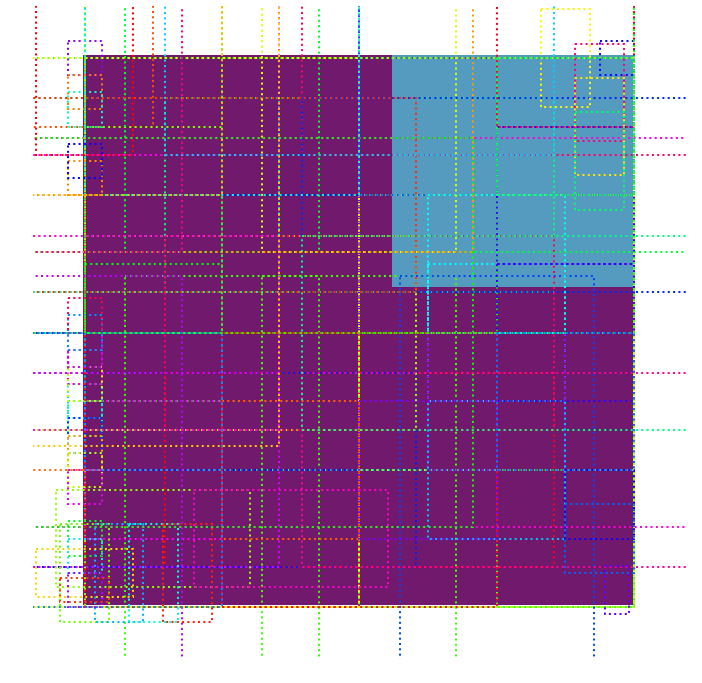

In [47]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]])

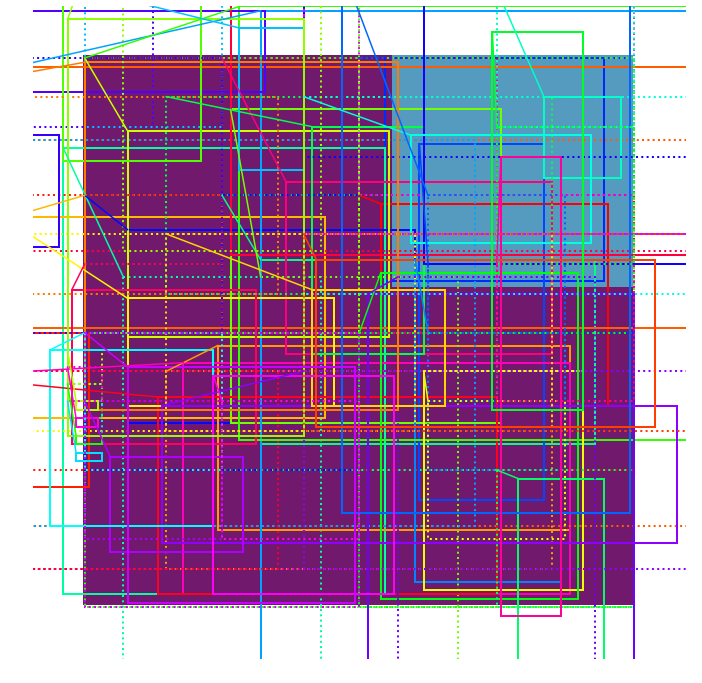

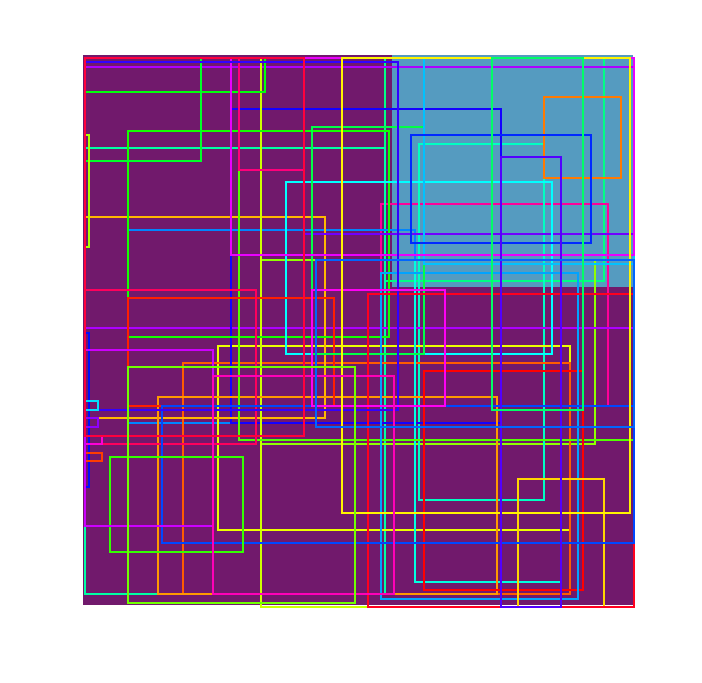

In [48]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit])

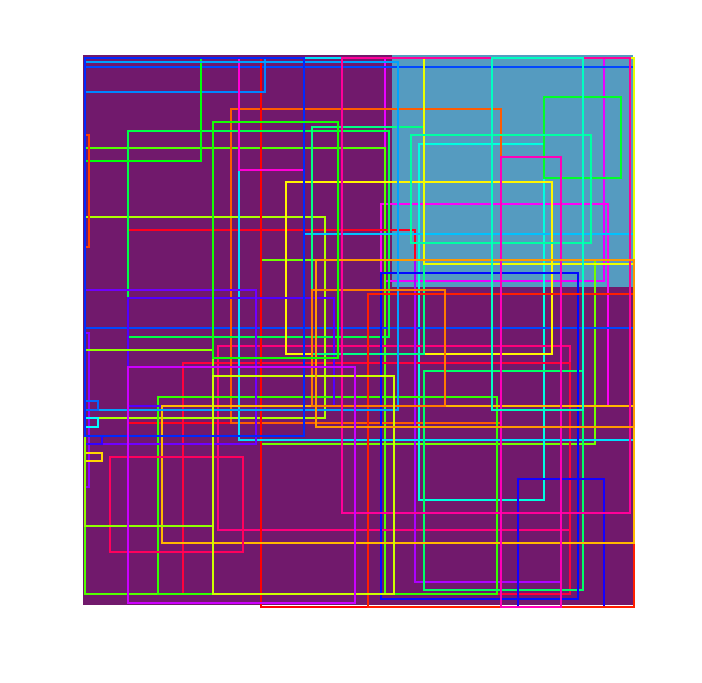

In [49]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs])

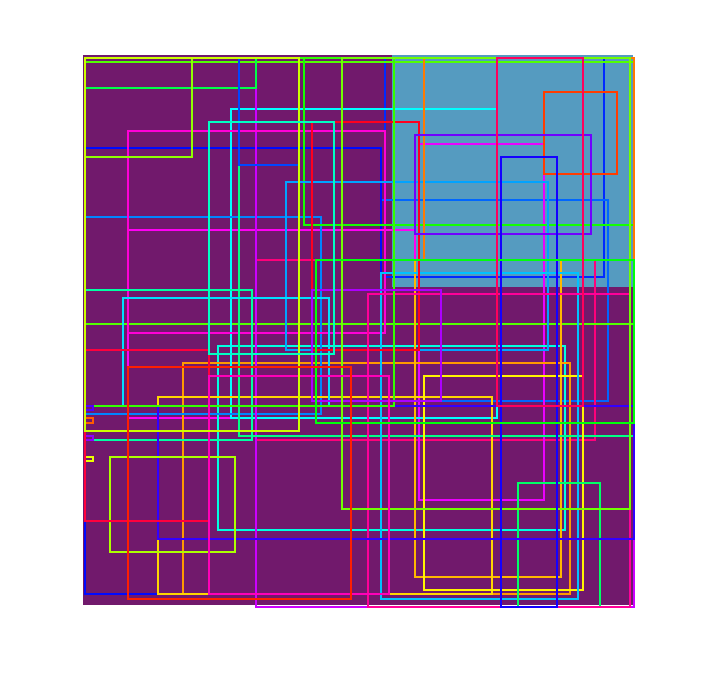

In [50]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals)

In [51]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors ( 4092)       Recall: 1.000  Positive anchors: 1
Refined Anchors ( 4092)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 1.000  Positive anchors: 2


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [52]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 4)          min:    0.00000  max:    0.99984  float32
deltas                   shape: (1, 1000, 4, 4)       min:  -13.14212  max:    6.86190  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.10411  max:    0.90733  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32


47 detections: ['square' 'square' 'square' 'square' 'square' 'circle' 'circle' 'square'
 'circle' 'square' 'circle' 'circle' 'circle' 'circle' 'circle' 'square'
 'square' 'square' 'square' 'square' 'square' 'square' 'square' 'circle'
 'square' 'square' 'square' 'circle' 'square' 'circle' 'circle' 'square'
 'square' 'square' 'square' 'circle' 'square' 'circle' 'square' 'square'
 'square' 'square' 'square' 'square' 'circle' 'square' 'circle']


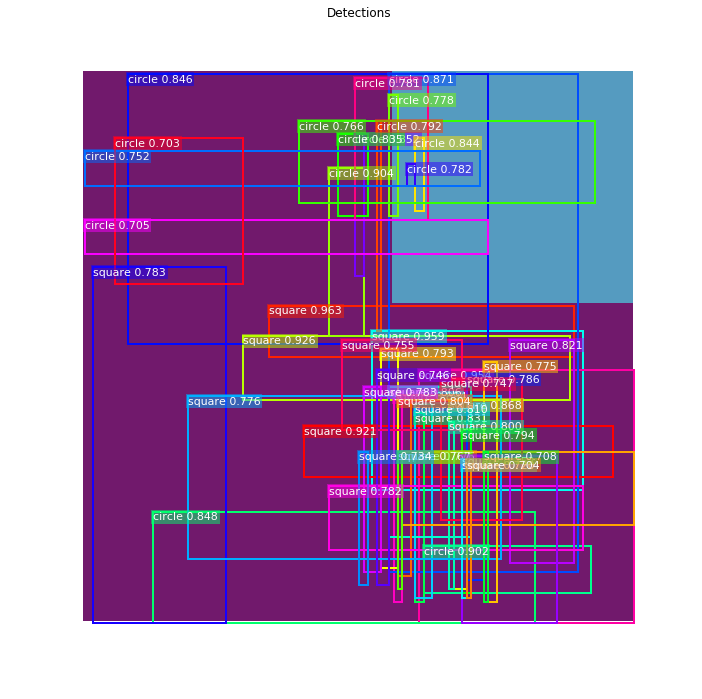

In [53]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections")

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [54]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
349 Positive ROIs
[('BG', 651), ('circle', 126), ('square', 217), ('triangle', 6)]


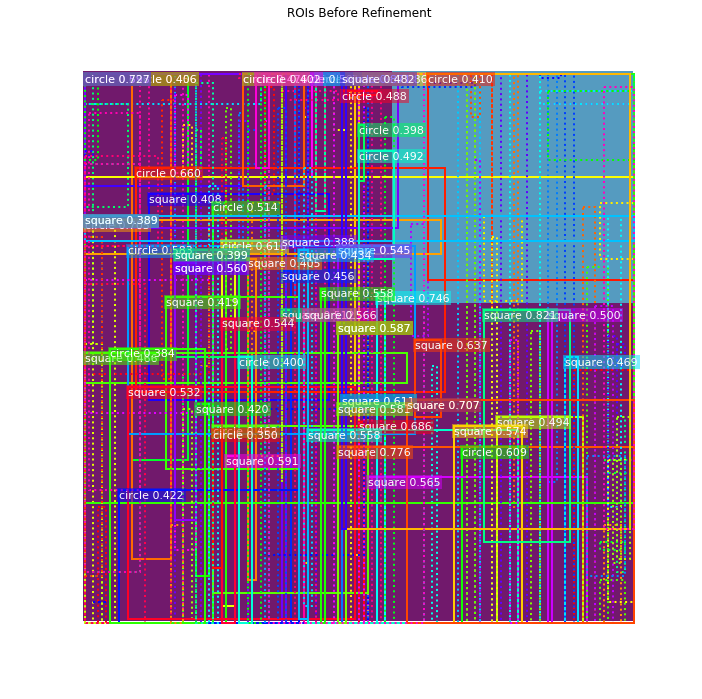

In [55]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement")

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:  -12.60854  max:    5.98381  float32
refined_proposals        shape: (1000, 4)             min: -143.00000  max:  192.00000  int32


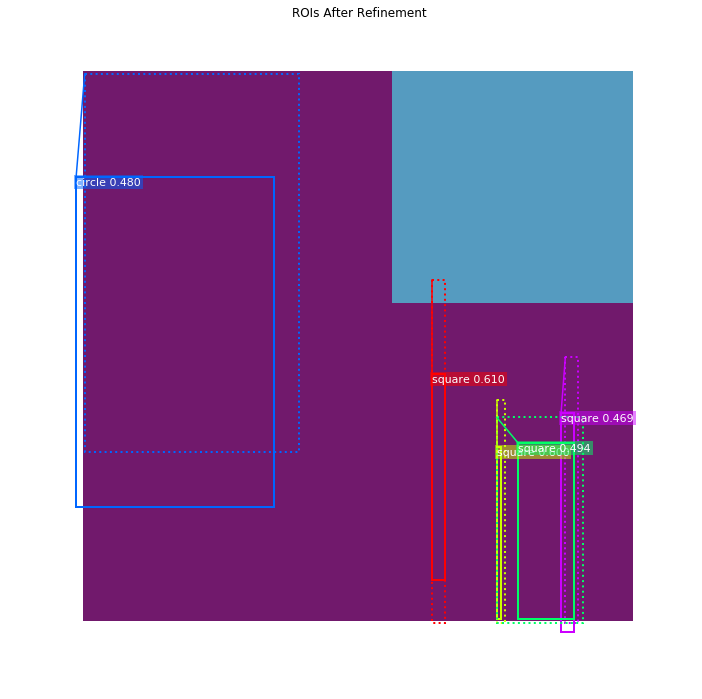

In [56]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [57]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 349 detections:
[  0   1   2   3   4   6   7   8  10  11  12  13  14  15  17  18  19  21
  23  24  25  26  28  29  31  32  36  37  39  44  45  46  47  48  49  54
  58  63  64  65  70  71  72  73  77  82  83  90  92  94  95  96  97 104
 106 111 112 113 117 125 126 129 134 137 138 139 140 142 146 147 153 156
 158 160 161 164 165 167 168 170 171 172 175 177 179 180 186 187 191 192
 193 194 196 198 199 203 209 211 212 213 215 217 220 222 228 229 230 231
 232 234 236 238 244 246 249 252 254 256 260 261 265 266 272 274 275 278
 280 281 282 284 287 289 291 292 297 299 300 303 309 310 311 313 314 317
 318 321 322 324 325 326 330 332 340 344 354 356 360 361 362 369 376 381
 386 389 395 398 404 409 410 412 414 415 423 427 428 429 433 434 453 459
 461 464 470 472 481 483 492 498 500 502 504 505 510 519 520 524 533 542
 549 550 552 556 558 563 564 567 569 570 573 574 575 577 578 580 581 585
 591 597 599 602 604 609 610 611 613 617 620 621 628 631 642 643 653 661
 662 664 665 668 670 672 678 6

In [58]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 73:
[  1   2   3  10  14  15  18  24  28  37  39  46  64  65  71  72  77 111
 129 134 137 138 147 153 160 192 203 215 217 220 222 232 236 244 249 254
 256 266 272 280 281 291 297 314 325 344 360 361 369 520 549 574 609 631
 661 672 715 737 747 763 765 780 853 883 902 903 914 916 925 927 955 966
 994]


#### Per-Class Non-Max Suppression

In [59]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

square                : [  1   3  10  18  24  28  37  46  65  71  72 111 137 138 147 153 215 217
 222 232 249 254 256 266 272 280 281 291 297 325 344 361 369 520 549 609
 631 661 672 737 747 763 780 853 883 902 916 925 966] -> [361   3  28 325  18 737 222 763 281 249 853 916 266 254 232  65 272 297
 291 215 661  37 280 780 902 549 631 966 883 925]
circle                : [  2  14  15  39  64  77 129 134 160 192 203 220 236 244 314 360 574 715
 765 903 914 927 955 994] -> [927 314  39 574 360 134 903 160 994 955 914 715  15 192 244 220 129]

Kept after per-class NMS: 47
[  3  15  18  28  37  39  65 129 134 160 192 215 220 222 232 244 249 254
 266 272 280 281 291 297 314 325 360 361 549 574 631 661 715 737 763 780
 853 883 902 903 914 916 925 927 955 966 994]


/userhome/comp3314/c3314g15/MaskRCNN-Extension/Final (Single Notebook)/mrcnn/utils.py:76: RuntimeWarning: invalid value encountered in true_divide
  iou = intersection / union
/userhome/comp3314/c3314g15/MaskRCNN-Extension/Final (Single Notebook)/mrcnn/utils.py:151: RuntimeWarning: invalid value encountered in greater
  remove_ixs = np.where(iou > threshold)[0] + 1


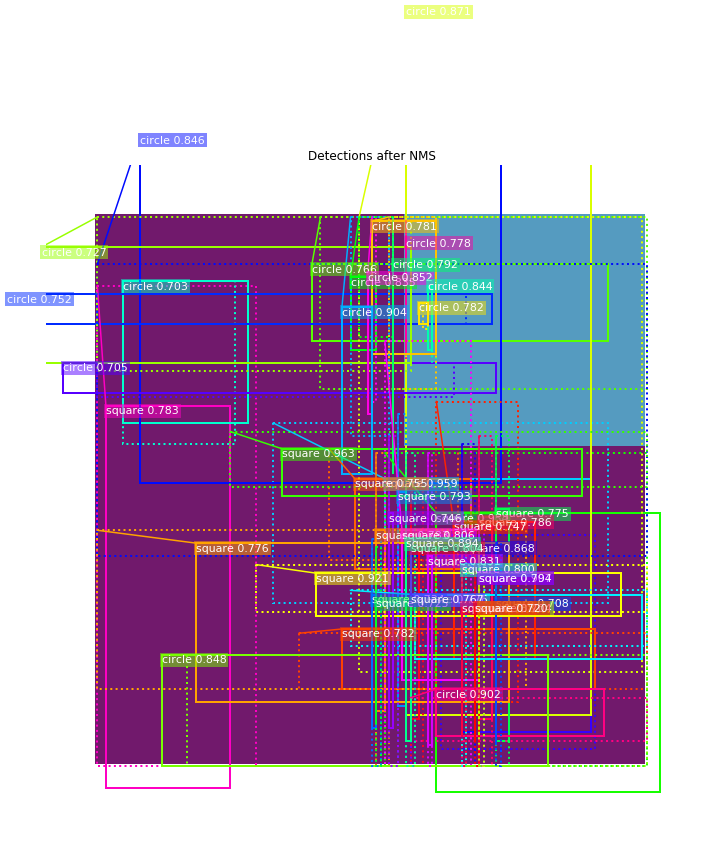

In [60]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS")

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

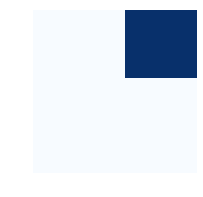

In [61]:
visualize.display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [62]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.10411  max:    0.90733  float32
47 detections: ['square' 'square' 'square' 'square' 'square' 'circle' 'circle' 'square'
 'circle' 'square' 'circle' 'circle' 'circle' 'circle' 'circle' 'square'
 'square' 'square' 'square' 'square' 'square' 'square' 'square' 'circle'
 'square' 'square' 'square' 'circle' 'square' 'circle' 'circle' 'square'
 'square' 'square' 'square' 'circle' 'square' 'circle' 'square' 'square'
 'square' 'square' 'square' 'square' 'circle' 'square' 'circle']


In [63]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (47, 28, 28)          min:    0.24311  max:    0.90613  float32
det_masks                shape: (47, 128, 128)        min:    0.00000  max:    1.00000  bool


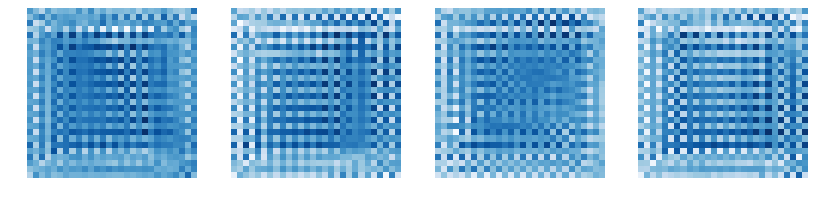

In [64]:
visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

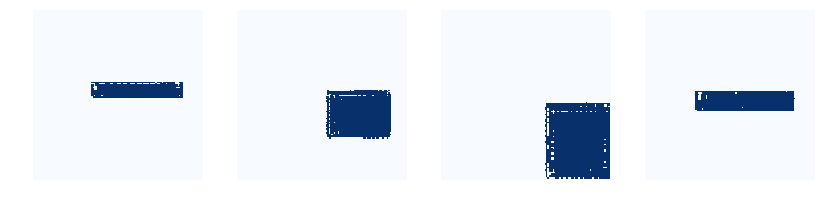

In [65]:
visualize.display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [66]:
import tensorflow as tf
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 128, 128, 3)      min:  -91.80000  max:   88.10000  float32
res4w_out                shape: (1, 8, 8, 1024)       min:    0.00000  max:   48.44231  float32
rpn_bbox                 shape: (1, 4092, 4)          min:  -23.57098  max:   46.55058  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


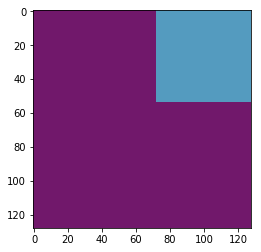

In [67]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

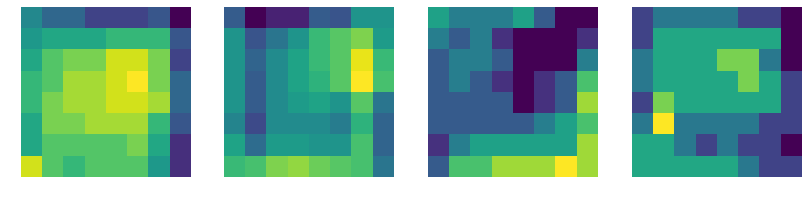

In [68]:
# Backbone feature map
visualize.display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

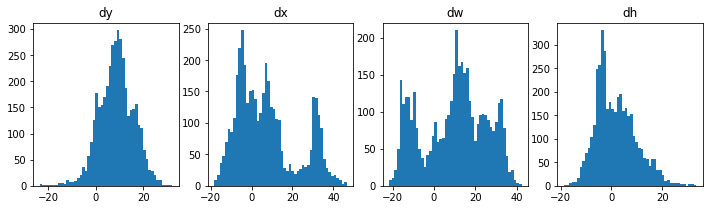

In [69]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

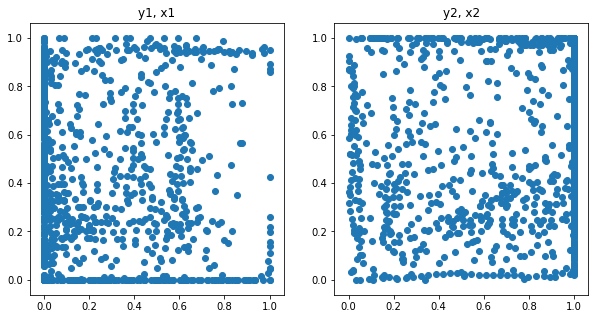

In [70]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()